# Chest x-ray diagnosis using deep learning models
## The model structure to study: DenseNet-121 (Densely Connected Convolutional Networks)
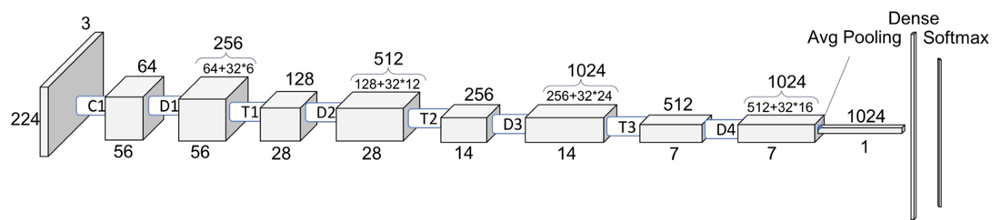

## Data Source: Stanford ChexPert Data - [CheXpert-v1.0-small]( https://stanfordmlgroup.github.io/competitions/chexpert/)

In [3]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#import pydotplus
#import pydot as pyd
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pyd

## data preprocessing
- Only frontal images 
- Only images considered as inputs to the model. "Sex", "Age", "Frontal/Lateral", and "AP/PA" features were removed from training data
- Combined the downloaded validation data with train data as the validation data size was very small (200 images)

In [4]:
dtrain=pd.read_csv("CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)
# import valid data info from valid.csv
dnew=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
#pre-process data: drop selected features - only images as inputs
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
print(dtrain.shape)
dtrain.describe().transpose()

(191229, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,191229.0,0.088899,0.284598,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,191229.0,-0.005198,0.319927,-1.0,0.0,0.0,0.0,1.0
Cardiomegaly,191229.0,0.087560,0.387350,-1.0,0.0,0.0,0.0,1.0
Lung Opacity,191229.0,0.470101,0.543553,-1.0,0.0,0.0,1.0,1.0
Lung Lesion,191229.0,0.031026,0.204087,-1.0,0.0,0.0,0.0,1.0
Edema,191229.0,0.198186,0.531517,-1.0,0.0,0.0,1.0,1.0
Consolidation,191229.0,-0.059437,0.438206,-1.0,0.0,0.0,0.0,1.0
Pneumonia,191229.0,-0.059081,0.323371,-1.0,0.0,0.0,0.0,1.0
Atelectasis,191229.0,-0.000356,0.558545,-1.0,0.0,0.0,0.0,1.0
Pneumothorax,191229.0,0.078398,0.317135,-1.0,0.0,0.0,0.0,1.0


 - Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were consdiered as positive (replaced -1 by 1)
 - Data statistics show Lung Opacity, Edema, Atelectasis, Pleural Effusion and Support Devices have more balanced positive versus negative cases. The resut of observations have less than 25% of positive observations

In [5]:
# dealing with uncertanty (-1) values
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No Finding,191229.0,0.088899,0.284598,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,191229.0,0.102380,0.303148,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,191229.0,0.157706,0.364466,0.0,0.0,0.0,0.0,1.0
Lung Opacity,191229.0,0.516444,0.499731,0.0,0.0,1.0,1.0,1.0
Lung Lesion,191229.0,0.042614,0.201985,0.0,0.0,0.0,0.0,1.0
Edema,191229.0,0.321787,0.467163,0.0,0.0,0.0,1.0,1.0
Consolidation,191229.0,0.195556,0.396629,0.0,0.0,0.0,0.0,1.0
Pneumonia,191229.0,0.108059,0.310456,0.0,0.0,0.0,0.0,1.0
Atelectasis,191229.0,0.311972,0.463299,0.0,0.0,0.0,1.0,1.0
Pneumothorax,191229.0,0.106720,0.308758,0.0,0.0,0.0,0.0,1.0


- The combined data were split into train, validation, and test sets. 10% of data were used for validation and test data. 

In [6]:
### split data into train/valid/test
dtrain = dtrain.sample(frac=1)
dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size
dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

In [7]:
print(dtr.shape)
dtr.describe().transpose()

(152984, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,152984.0,0.088839,0.284513,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,152984.0,0.102337,0.303093,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,152984.0,0.157337,0.364119,0.0,0.0,0.0,0.0,1.0
Lung Opacity,152984.0,0.515917,0.499748,0.0,0.0,1.0,1.0,1.0
Lung Lesion,152984.0,0.042665,0.202100,0.0,0.0,0.0,0.0,1.0
Edema,152984.0,0.321321,0.466985,0.0,0.0,0.0,1.0,1.0
Consolidation,152984.0,0.195249,0.396394,0.0,0.0,0.0,0.0,1.0
Pneumonia,152984.0,0.107756,0.310073,0.0,0.0,0.0,0.0,1.0
Atelectasis,152984.0,0.312222,0.463401,0.0,0.0,0.0,1.0,1.0
Pneumothorax,152984.0,0.107096,0.309236,0.0,0.0,0.0,0.0,1.0


In [8]:
print(dv.shape)
dv.describe().transpose()

(19124, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,19124.0,0.089992,0.286177,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,19124.0,0.103796,0.305004,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,19124.0,0.156453,0.363293,0.0,0.0,0.0,0.0,1.0
Lung Opacity,19124.0,0.516158,0.499752,0.0,0.0,1.0,1.0,1.0
Lung Lesion,19124.0,0.041780,0.200091,0.0,0.0,0.0,0.0,1.0
Edema,19124.0,0.320697,0.466757,0.0,0.0,0.0,1.0,1.0
Consolidation,19124.0,0.193526,0.395072,0.0,0.0,0.0,0.0,1.0
Pneumonia,19124.0,0.109810,0.312661,0.0,0.0,0.0,0.0,1.0
Atelectasis,19124.0,0.310291,0.462625,0.0,0.0,0.0,1.0,1.0
Pneumothorax,19124.0,0.107770,0.310098,0.0,0.0,0.0,0.0,1.0


In [9]:
print(dte.shape)
dte.describe().transpose()

(19123, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,19123.0,0.088323,0.283771,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,19123.0,0.101292,0.301722,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,19123.0,0.161952,0.368416,0.0,0.0,0.0,0.0,1.0
Lung Opacity,19123.0,0.520891,0.499576,0.0,0.0,1.0,1.0,1.0
Lung Lesion,19123.0,0.043037,0.202946,0.0,0.0,0.0,0.0,1.0
Edema,19123.0,0.326622,0.468990,0.0,0.0,0.0,1.0,1.0
Consolidation,19123.0,0.200021,0.400026,0.0,0.0,0.0,0.0,1.0
Pneumonia,19123.0,0.108717,0.311292,0.0,0.0,0.0,0.0,1.0
Atelectasis,19123.0,0.311614,0.463165,0.0,0.0,0.0,1.0,1.0
Pneumothorax,19123.0,0.102651,0.303511,0.0,0.0,0.0,0.0,1.0


 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

In [10]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
#target_size = (299,299)
#target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:15]), class_mode="other", target_size=target_size, batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , x_col="Path", y_col=list(dv.columns[1:15]), class_mode="other", target_size=target_size, batch_size=32)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , x_col="Path", y_col=list(dte.columns[1:15]), class_mode="other", target_size=target_size, shuffle = False, batch_size=1)


Found 152984 images.
Found 19124 images.
Found 19123 images.


- DenseNet-121 is selected for CNN structure. A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify DenseNet-121 architecture for our application. The weights are initialized with a network weights tuned for imagenet data. 
- loss function is defined as binary cross entropy loss. <font color=blue>Only new layers are trained. All baseline convolutional layers are freezed for tuning. This is to transfer learning from imagenet classification pre-trained model.</font>
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
- The model parameters statistics are: <font color=blue>Total params: 8,101,454, Trainable params: **1,063,950**, Non-trainable params: 7,037,504</font>

In [4]:
### model architecture design/selection
# create the base pre-trained model
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(14, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________________

In [5]:
### fit model 
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)
# save model
model.save("model_DenseNet121_TF.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
4780/4780 [==============================] - 1687s 353ms/step - loss: 0.4024 - acc: 0.8189 - val_loss: 0.4295 - val_acc: 0.8069
Epoch 2/3
4780/4780 [==============================] - 1472s 308ms/step - loss: 0.3943 - acc: 0.8228 - val_loss: 0.4532 - val_acc: 0.8028
Epoch 3/3
4780/4780 [==============================] - 1472s 308ms/step - loss: 0.3918 - acc: 0.8239 - val_loss: 0.4372 - val_acc: 0.8077


Calculate precision, recall, f1-score on test data. **The threshold for positive is set to 0.5**

In [7]:
###load the model if it was saved before
#model = load_model('model.h5')
#model.summary()

### prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.45      0.19      0.27      1679
Enlarged Cardiomediastinum       0.00      0.00      0.00      1880
              Cardiomegaly       0.26      0.24      0.25      2991
              Lung Opacity       0.65      0.37      0.47      9908
               Lung Lesion       0.00      0.00      0.00       810
                     Edema       0.59      0.14      0.22      6203
             Consolidation       0.00      0.00      0.00      3824
                 Pneumonia       0.00      0.00      0.00      2049
               Atelectasis       0.00      0.00      0.00      6047
              Pneumothorax       0.00      0.00      0.00      2084
          Pleural Effusion       0.64      0.46      0.53      8740
             Pleural Other       0.00      0.00      0.00       431
                  Fracture       0.00      0.00      0.00       787
           Support Devices       0.65      0.85

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [8]:
score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.4406790353997927
Test accuracy: 0.8065381217098246
